# Emission Spectra Model Visuals

Contribution visuals are an important tool for interpreting forward models and retrieved spectra. 

We differentiate here between two types of contribution visuals: (i) *spectral decomposition plots*, which highlight the impact of each chemical species on a spectrum; and (ii) *pressure contribution plots*, which highlight the atmospheric layers driving the formation of spectral features.

In this notebook, we will take HD 189733 b as an example forward model and analyse:

1. The spectral components of an emission spectrum in terms of brightness temperature.
2. Where in the forward model atmosphere the spectrum forms.
3. Which pressure regions are probed at different wavelengths.

We note that on the release of POSEIDON V1.2 (September 2024), contribution functions are slower than the nominal forward model capability of POSEIDON. These functions will be sped up in a subsequent hotfix update.

For the entirety of this notebook, we will assume some familiarity with the transmission spectra version of this notebook ([\"Transmission Spectra Model Visuals\"](transmission_contributions.html)).

However, we stress that pressure contribution visuals tend to be more pertinent for emission spectra than transmission. This is because in emission, gas species can only impart spectral features where there is a thermal gradient (thermal inversions cause emission features, thermal decline cause absorption features) and therefore can probe specific regions of the atmosphere.

First, let's define our wavelength, planet, star, model, and opac objects.

All of these steps are the same as any forward model with POSEIDON.

In [1]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities
import numpy as np

#***** Model wavelength grid *****#

wl_min = 0.4    # Minimum wavelength (um)
wl_max = 12     # Maximum wavelength (um)
R = 1000        # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

In [2]:
#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J   # Planetary mass (kg)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p)

In [3]:
#***** Define stellar properties *****#

R_s = 0.751*R_Sun    # Stellar radius (m)
T_s = 5052           # Stellar effective temperature (K)
Met_s = 0.13         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

Let's define the planet with a simple chemical chemical inventory, consisting of $\rm{H_2O}$ and $\rm{CO_2}$ in a clear atmosphere.

In [4]:
model_name_contribution_emission = 'Contribution-Emission'

#***** Define model *****#

bulk_species = ['H2', 'He']
param_species = ['CO2','H2O'] # < --- For simplicity, just two species 

# Create the model object
model_contribution_emission = define_model(model_name_contribution_emission,
                                           bulk_species, param_species, 
                                           PT_profile = 'Guillot_dayside',  # < --- A non-isothermal PT profile for emission
                                           ) 

In [5]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3000   # Same as prior range for T
T_fine_step = 10    # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-8   # 10 nbar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1 

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model_contribution_emission, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO2 done
H2O done
Opacity pre-interpolation complete.


Let's define our forward model atmosphere. Here I have pulled the retrieved values of an HD 189733 b emission retrieval performed and reported in Mullens et al 2024.

In [6]:
from POSEIDON.core import make_atmosphere

R_p_ref      =   1.12 * R_J

log_kappa_IR =   -4.83 
log_gamma    =   -0.41 
T_int        =   262.8
T_equ        =   1158.0

log_CO2      =   -3.12
log_H2O      =   -5.39

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])
log_X_params = np.array([log_CO2, log_H2O])

# Make atmosphere 
atmosphere_contribution_emission = make_atmosphere(planet, model_contribution_emission, 
                                                   P, P_ref, R_p_ref, PT_params, log_X_params)

Let's take a look at the resultant pressure-temperature profile 

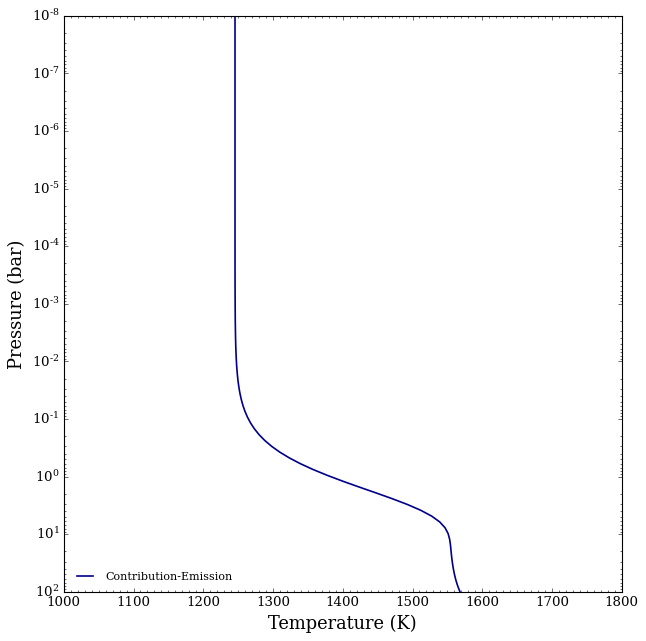

In [7]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_contribution_emission, 
                 atmosphere_contribution_emission, log_P_max = 2.0)

Since for gas-phase species, absorption or emission features only form in portions of the atmosphere where there is a thermal gradient (here from 100 to 0.1 bars), we can already make some predictions that those pressures is where most of the spectral features will be forming.

Before diving into the spectral contributions plots, let's just generate the forward model spectrum.

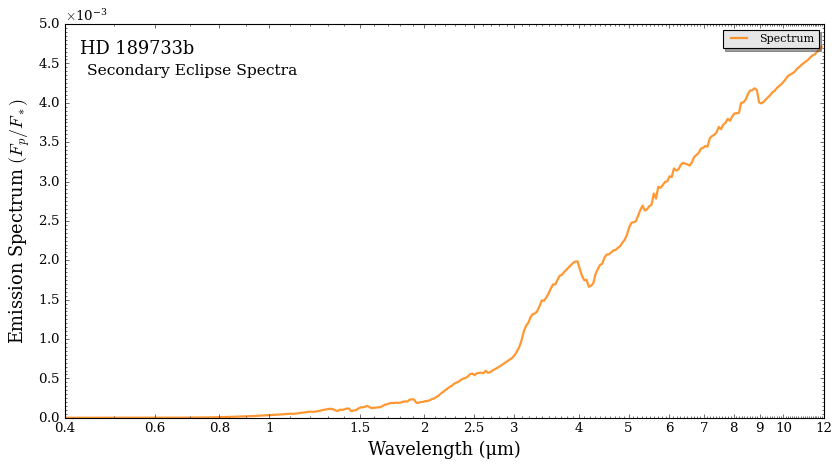

In [8]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate secondary eclipse spectra
Fp_Fs = compute_spectrum(planet, star, model_contribution_emission, 
                         atmosphere_contribution_emission, opac, wl, 
                         spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs, wl, collection = spectra)

title = 'Secondary Eclipse Spectra'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth',
                        legend_location = 'upper right', wl_axis = 'log',
                        colour_list = ['#ff7f00'],
                        plt_label = title,
                        figure_shape = 'wide',
                        )

Without having to pull out a textbook of cross sections, let's figure out what is causing all the bumps and wriggles we are seeing.

## Spectral Decomposition 

The spectral contribution function (`spectral_contribution`) found in contributions.py helps visualize the spectral components of specific species and their contribution to the spectrum. 

This is the same as in the transmission tutorial, except we must now set the `spectrum_type` as emission.

In [9]:
from POSEIDON.contributions import spectral_contribution, plot_spectral_contribution

FpFs, FpFs_list_names, \
FpFs_contribution = spectral_contribution(planet, star, model_contribution_emission,
                                          atmosphere_contribution_emission, 
                                          opac, wl,
                                          spectrum_type = 'emission',                 # < ---- Change spectrum type to emission!
                                          contribution_species_list = ['H2O', 'CO2'], # <---- List the gas phase species 
                                          bulk_species = True,                        #< Bulk Species contribution (H2 + He)
                                          cloud_contribution = False,
                                          )

To plot, use the `plot_spectral_contribution` function.

This is the same as in transmission, except now we have the option to view either the emission spectrum, or to turn it to brightness temperature. 

In this unit, contributions can be bit easier to see for emission spectra. It also can signify which portion of the spectra is probing which region of the atmosphere (which part of the PT profile is producing the signal)

Before viewing the contribution in brightness temperature, let's take a look at how it looks in standard eclipse units ($F_p / F_s$).

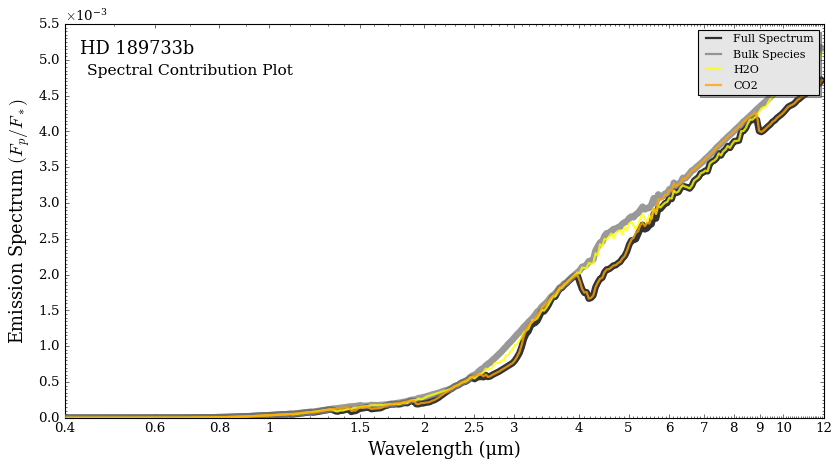

In [10]:
fig = plot_spectral_contribution(planet, wl, FpFs, FpFs_list_names, FpFs_contribution,
                                 line_widths = [6,6,2,2],
                                 colour_list = ['black', 'gray', 'yellow','orange',],
                                 brightness_temperature = False,
                                 star = star,                  # <--- Include the star for emission
                                 y_unit = 'eclipse_depth',     # <--- Remember the y_unit for emission spectra
                                 return_fig = True,
                                )

From above, we can see that $\rm{CO_2}$ absorption dominates the spectrum (in that it is forming most of the absorption features) whereas the bulk species provides the black-body spectrum devoid of features. We will now look at this in brightness temperature.

The formula for brightness temperature is just solving the Planck function (the blackbody formula) for temperature:

$T_{bright}(\lambda) = \left(\frac{hc}{k_b \lambda}\right) \left(\ln\left[1 + \frac{2 h c^2}{(F_{p, \lambda}/\pi) \lambda^5}\right] \right)^{-1}$

Brightness temperature is useful in that it amplifies features in the spectrum, and it also helps pin-point to the temperature in the atmosphere the spectrum is forming. A general rule of thumb is that the spectrum in longer wavelengths (mid-infrared) typically forms higher up (lower pressures) in the atmosphere whereas the shorter wavelengths form deeper (in hotter portions) of the atmosphere.

We can flip the spectral contribution into brightness temperature by setting it to True in the function below. 

DISCLAIMER: The following function will change FpFs and FpFs_contribution to brightness temperature permanently. To revert back to FpFs, rerun the two cells before this one.

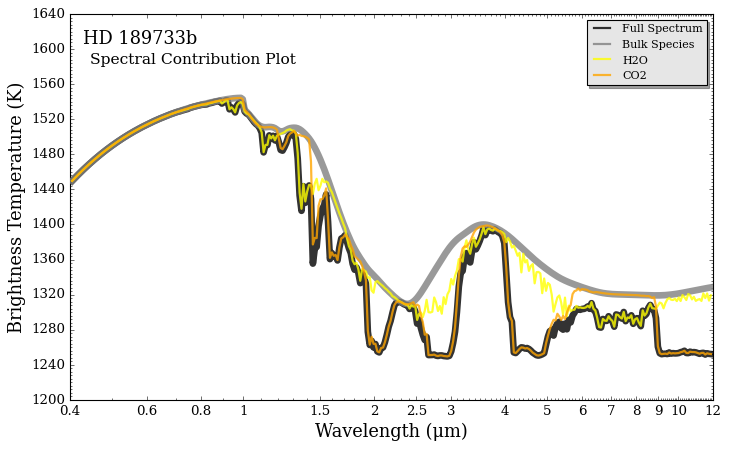

<Figure size 853.36x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

fig_combined = plt.figure(constrained_layout=True, figsize=(9, 5.5))    # Change (9,5.5) to alter the aspect ratio

# This function is the magic. Each letter corresponds to one matplotlib axis, which you can then pass to POSEIDON's plotting functions
axd = fig_combined.subplot_mosaic(
    """
    AAAA
    AAAA
    """
)

fig = plot_spectral_contribution(planet, wl, FpFs, FpFs_list_names, FpFs_contribution,
                                 return_fig = True,
                                 line_widths = [6,6,2,2],
                                 colour_list = ['black', 'gray', 'yellow','orange',],
                                 ax = axd['A'],
                                 brightness_temperature = True,   # <--- Set brightness temperature to True
                                 star = star,                     # <--- Remember to include the star for emission
                                 y_min = 1200, y_max = 1640,
                                )

## Pressure Contribution

The pressure contribution function goes layer by layer, removes an opacity source, and recomputes the spectrum, and takes the difference with the full spectrum. 

There is an option to do the total pressure contribution (which removes each layers entire opacity source) or specific opacity sources.

Do note, however, that this process is very slow, but very useful for analysing which pressures in the forward model the spectrum is probing. We recommend setting the spectral resolution to $R = 1000$ and remaking the opac object before running the following code.

We compute the total pressure contribution and water's pressure contribution below.

Since this is emission, we expect the majority of contribution to come from where there is a temperature gradient, specifically the 10 to 0.1 bar region,

To create the pressure contribution, run the `pressure_contribution` function below, which has has a similar set up to the spectral contribution function above. Here we have verbose turned on, which prints the layer number the function is on (the Pressure array has 100 layers), which is a good gauge for how long the spectrum will take to compute.

Contribution is an array with dimensions P vs wl vs contribution species. The norm is returned, but not used. The list names is used in plotting.

The plotting functions will return a normal contribution plot, and then a log version.

Let's look at the total pressure contribution first.

In [12]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution, norm, \
spectrum_contribution_list_names = pressure_contribution(planet, star, model_contribution_emission, 
                                                         atmosphere_contribution_emission, opac, wl,
                                                         spectrum_type = 'emission',
                                                         bulk_species = False, 
                                                         cloud_contribution = False, 
                                                         total_pressure_contribution=True,
                                                         )

Progress: 100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


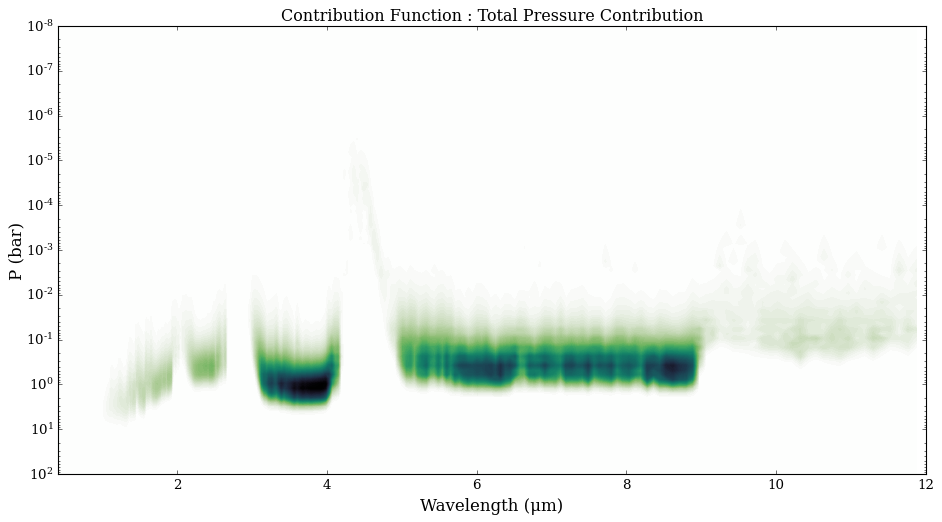

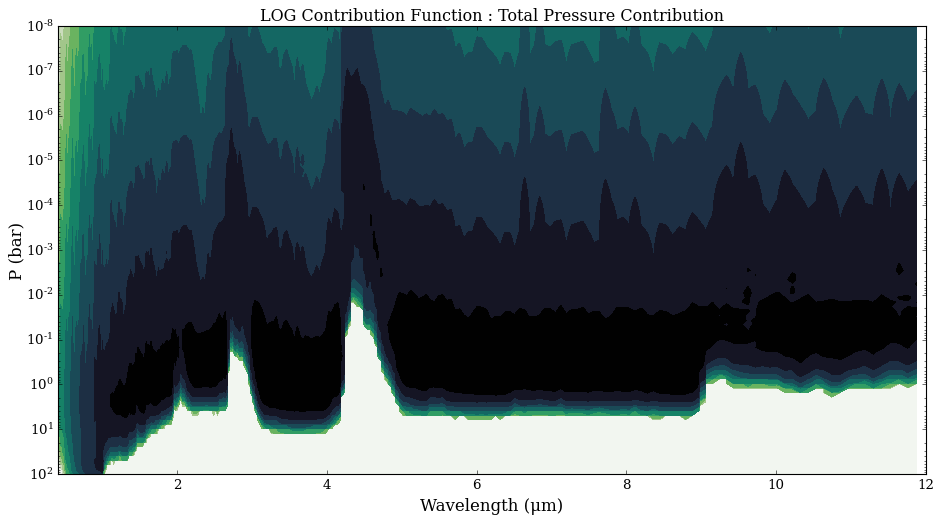

In [13]:
plot_pressure_contribution(wl,P,Contribution, spectrum_contribution_list_names, R = 100) 

As we predicted, a majority of the spectrum is forming in the pressure region where there is a temperature gradient. Now let's look at just water.

In [14]:
from POSEIDON.contributions import pressure_contribution, plot_pressure_contribution

Contribution_water, norm_water, \
spectrum_contribution_list_names_water = pressure_contribution(planet, star, model_contribution_emission, 
                                                               atmosphere_contribution_emission, opac, wl,
                                                               spectrum_type = 'emission',
                                                               contribution_species_list = ['H2O'],
                                                               bulk_species = False, 
                                                               cloud_contribution = False, 
                                                               total_pressure_contribution = False,
                                                               )

Progress: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


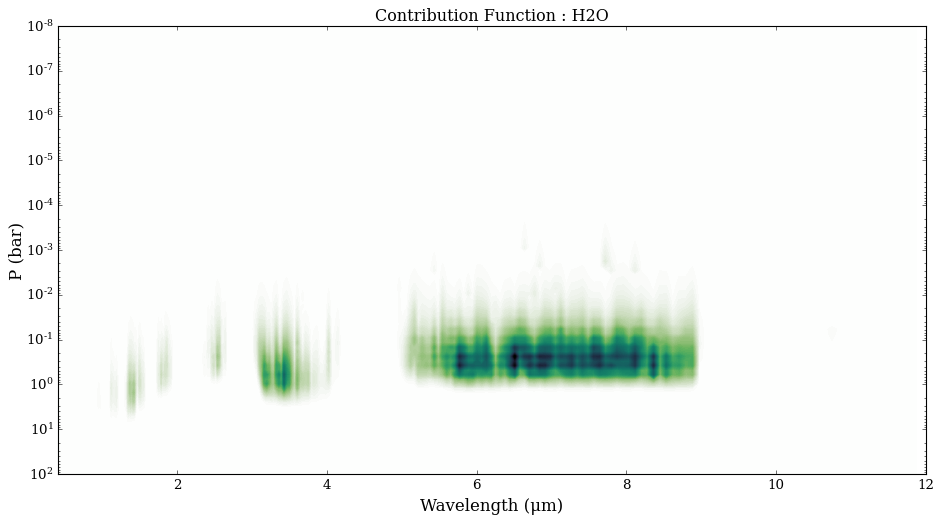

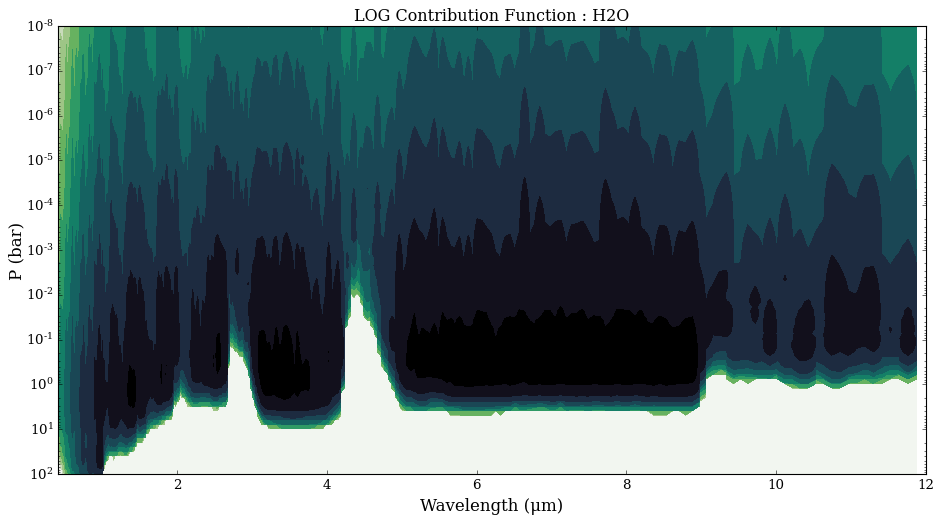

In [15]:
plot_pressure_contribution(wl,P,Contribution_water, spectrum_contribution_list_names_water, R = 100) 

## Photometric Contribution 

The pressure contribution function can also be integrated over a specific wavelength range to produce a `photometric' pressure contribution function. 

We recommend wavelength bins of size $\Delta \lambda = 1$   um, to show which pressure layers contribute most over a given wavelength range.

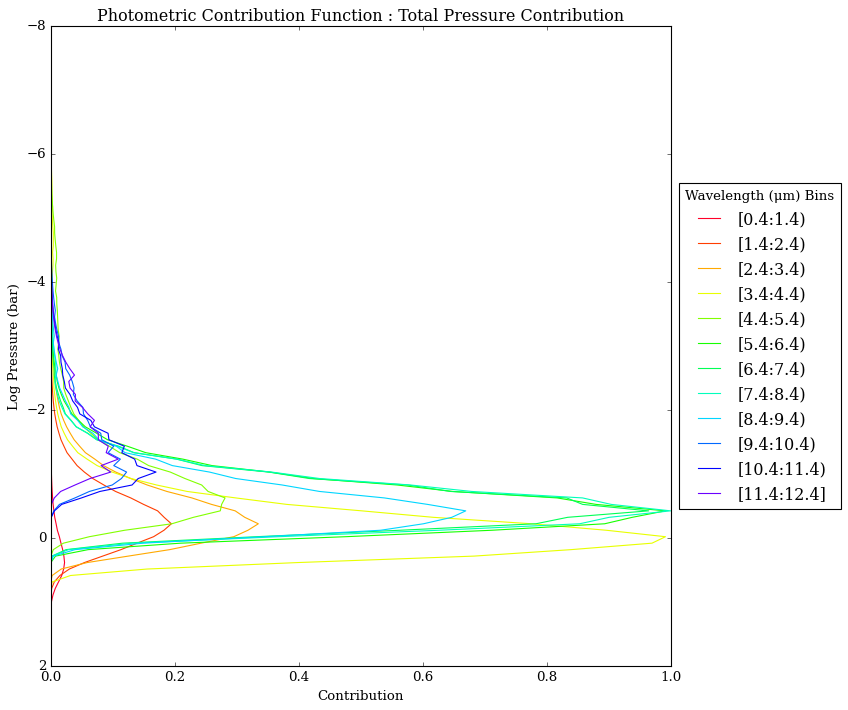

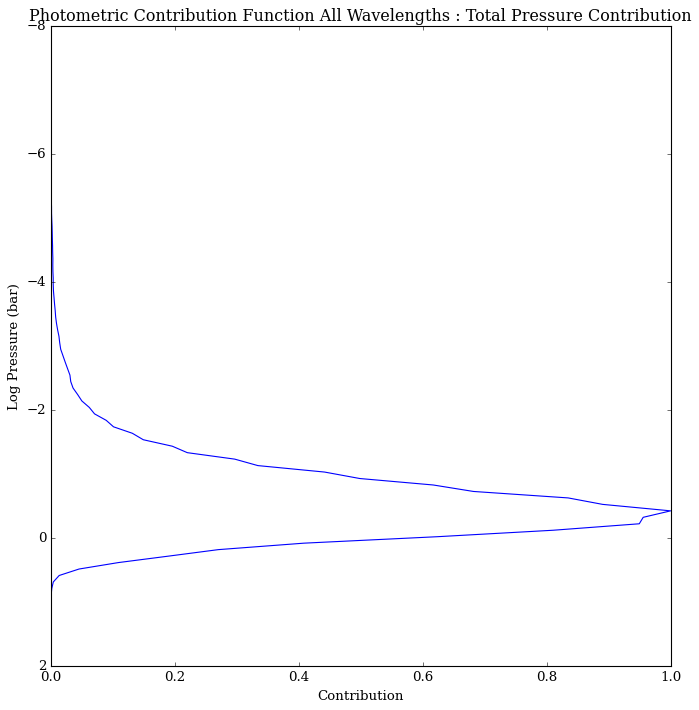

In [16]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, \
photometric_total, bins = photometric_contribution_function(wl, P, Contribution, 
                                                            spectrum_contribution_list_names,
                                                            binsize = 1)

plot_photometric_contribution(wl,P, photometric_contribution, photometric_total,
                              spectrum_contribution_list_names, bins = bins)

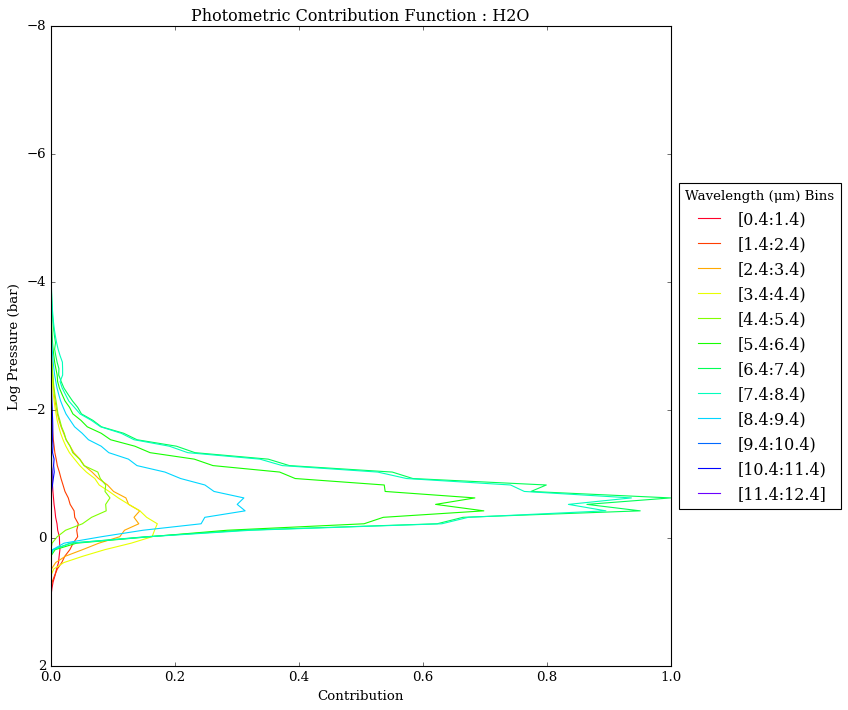

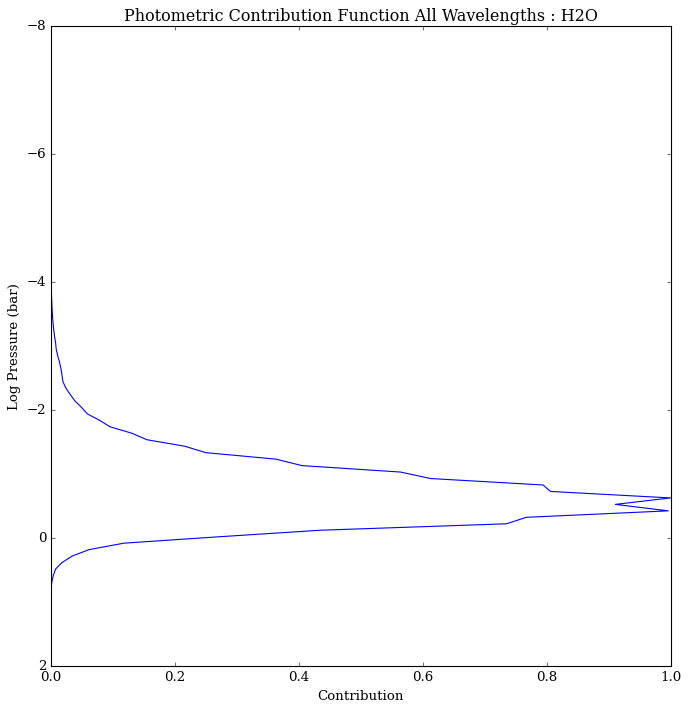

In [17]:
from POSEIDON.contributions import photometric_contribution_function, plot_photometric_contribution

photometric_contribution, \
photometric_total, bins = photometric_contribution_function(wl, P, Contribution_water, 
                                                            spectrum_contribution_list_names_water,
                                                            binsize = 1)

plot_photometric_contribution(wl,P, photometric_contribution, photometric_total,
                              spectrum_contribution_list_names_water, bins = bins)